# Experiment 6: T5-small

#### Reference: Exploring the limits of transfer learning with a unified text-to-text transformer (Raffel et al., 2020)

Hyperparameters used in experiment 6:
- d_model = 128
- num_heads = 2
- d_ff = 256

List of experiments:
- d_model = (64, **128**, 256)
- num_heads = (**2**, 4, 8)
- d_ff = (128, **256**, 512)

## Import libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import sys
!{sys.executable} -m pip install transformers sentencepiece

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from datasets import load_dataset
from transformers import T5Tokenizer
from transformers import Adafactor
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
from collections import Counter, defaultdict

## Load dataset, split train & test

In [4]:
dataset = load_dataset("sciq")
train_data = dataset["train"]
test_data = dataset["test"]
val_data = dataset["validation"]

## Tokenization, padding, truncation

In [5]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

MAX_INPUT_LEN = 64
MAX_TARGET_LEN = 16

def preprocess(example):
    input_text = f"question: {example['question']}"
    target_text = example["correct_answer"]

    input_enc = tokenizer(
        input_text,
        padding="max_length",
        truncation=True,
        max_length=MAX_INPUT_LEN
    )

    target_enc = tokenizer(
        target_text,
        truncation=True,
        max_length=MAX_TARGET_LEN - 1
    )

    target_ids = target_enc.input_ids + [tokenizer.eos_token_id]
    target_ids = target_ids[:MAX_TARGET_LEN]
    pad_len = MAX_TARGET_LEN - len(target_ids)
    target_ids += [tokenizer.pad_token_id] * pad_len

    return {
        "input_ids": torch.tensor(input_enc.input_ids),
        "attention_mask": torch.tensor(input_enc.attention_mask),
        "labels": torch.tensor(target_ids),
    }

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Karena baseline yang digunakan T5-small, maka menggunakan tokenizer T5-small juga. Alasannya agar vocab dan encoding yang digunakan sama seperti baseline.

- Maksimal 64 token input (question).
- Maksimal 16 token target (answer).

Jika lebih dari itu, maka akan di-truncate (truncation = true)

MAX_TARGET_LEN - 1 untuk menyisakan ruang untuk eos_token_id

In [6]:
print(tokenizer.vocab_size)

32000


## PyTorch dataset wrapper

In [7]:
class SciQDataset(Dataset):
    def __init__(self, hf_dataset):
        self.data = [preprocess(x) for x in hf_dataset]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

## Create data loaders

In [8]:
train_dataset = SciQDataset(train_data)
val_dataset = SciQDataset(val_data)

g = torch.Generator()
g.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Menggunakan seed generator agar hasil shuffle dapat direproduksi ulang.

## Positional encoding

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=64):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Pada T5 pre-trained tidak menggunakan sinusoidal positional encoding tetapi relative position bias (RPB). Namun karena RPB terlalu kompleks untuk baseline model from scratch, saya tetap menggunakan sinusoidal positional encoding.

## Masking function

In [10]:
def generate_causal_mask(size):
    mask = torch.tril(torch.ones(size, size)).unsqueeze(0).unsqueeze(0)
    return mask

Fungsi masking agar posisi token hanya dapat melihat dirinya sendiri dan token sebelumnya.

## Attention layer

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None, kv=None):
        if kv is None:
            kv = x

        B, T_q, _ = x.size()
        B, T_kv, _ = kv.size()

        q = self.q_proj(x).view(B, T_q, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(kv).view(B, T_kv, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(kv).view(B, T_kv, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn_weights = self.dropout(F.softmax(scores, dim=-1))

        out = torch.matmul(attn_weights, v).transpose(1, 2).contiguous().view(B, T_q, -1)
        return self.out_proj(out)

Linear projections mengubah input menjadi query, key, value untuk setiap token:
- self.q_proj = nn.Linear(d_model, d_model)
- self.k_proj = nn.Linear(d_model, d_model)
- self.v_proj = nn.Linear(d_model, d_model)

Input d_model dipecah menjadi beberapa head agar model dapat fokus ke berbagai bagian input secara paralel:
- self.num_heads = num_heads
- self.head_dim = d_model // num_heads

Pada decoder digunakan masking agar token tidak dapat melihat masa depan:
- scores = scores.masked_fill(mask == 0, float('-inf'))

## Norm layer

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.eps = eps

    def forward(self, x):
        variance = x.pow(2).mean(-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.weight

- Norm layer digunakan untuk menstabilkan dan mempercepat pelatihan dengan menormalisasikan nilai fitur setiap token.
- Norm layer pada T5 hanya menghitung variance, tidak menggunakan mean centering.

## Feed forward layer

In [13]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

- Baseline yang digunakan mengacu pada arsitektur T5 dari paper Raffel et al. (2020) yaitu menggunakan fungsi aktivasi ReLU.
- Namun pre-trained T5 saat ini (versi 1.1) menggunakan fungsi aktivasi GeLU.

## Encoder

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask=mask))
        x = x + self.dropout(self.ff(self.norm2(x)))
        return x

Encoder terdiri dari:
- Multi head self attention
- Feed forward
- Layer normalization
- Dropout

Residual connection:
- X adalah representasi input token yang sedang diproses.
- X dinormalisasi menggunakan norm1, masuk ke multi head self attention, dropout, ditambahkan kembali ke nilai X sebagai residual connection (X').
- X' dinormalisasi menggunakan norm2, masuk ke feed forward, dropout, ditambahkan kembali ke nilai X' sebagai residual connection (X'').

T5 menggunakan pre-LN:
- Urutan: layer norm -> attention/feed forward -> residual

## Decoder

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)

        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        self.norm3 = LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, self_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attn(self.norm1(x), mask=self_mask))
        x = x + self.dropout(self.cross_attn(self.norm2(x), kv=enc_out, mask=cross_mask))
        x = x + self.dropout(self.ff(self.norm3(x)))
        return x

Decoder terdiri dari:
- Masked self attention
- Cross attention
- Feed forward
- Layer normalization
- Dropout

Residual connection:
- X adalah representasi input token yang sedang diproses.
- X dinormalisasi menggunakan norm1, masuk ke masked self attention, dropout, ditambahkan kembali ke nilai X sebagai residual connection (X').
- X' dinormalisasi menggunakan norm2, masuk ke cross attention, dropout, ditambahkan kembali ke nilai X' sebagai residual connection (X'').
- X'' dinormalisasi menggunakan norm3, masuk ke feed forward, dropout, ditambahkan kembali ke nilai X'' sebagai residual connection (X''').

T5 menggunakan pre-LN:
- Urutan: layer norm -> attention/cross-attention/feed forward -> residual

## Tranformer model

In [16]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len=64, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.enc_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dec_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.out = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )
        self.out.weight = self.tok_emb.weight

    def forward(self, src, tgt):
        src = self.dropout(self.pos_enc(self.tok_emb(src)))
        tgt = self.dropout(self.pos_enc(self.tok_emb(tgt)))

        tgt_mask = generate_causal_mask(tgt.size(1)).to(tgt.device)

        for layer in self.enc_layers:
            src = layer(src)

        for layer in self.dec_layers:
            tgt = layer(tgt, src, self_mask=tgt_mask)

        return self.out(tgt)

Mengubah token ID menjadi vektor embedding berdimensi d_model:
- tok_emb = nn.Embedding()

Menambahkan posisi ke vektor token:
- pos_enc = PositionalEncoding()

Dropout untuk mencegah overfitting:
- dropout = nn.Dropout()

Layer encoder sejumlah num_layers:
- enc_layers = nn.ModuleList()

Layer decoder sejumlah num_layers:
- dec_layers = nn.ModuleList()

Layer akhir untuk memproyeksikan hasil decoder ke distribusi token:
- out = nn.Sequential()

Weight tying (bagian dari arsitektur T5), sharing bobot antara embedding & output projection:
- self.out.weight = self.tok_emb.weight

Masking mencegah untuk melihat informasi masa depan saat training:
- tgt_mask = generate_causal_mask()

Encoder membentuk representasi semantik kontekstual dari input:
- for layer in enc_layers: src = layer(src)

Decoder melihat prediksi autoregresif berbasis target dan representasi encoder:
- for layer in dec_layers: tgt = layer(tgt, src, self_mask=tgt_mask)

Output berupa proyeksi logits untuk setiap token posisi (distribusi probabilitas token berikutnya):
- self.out(tgt)

## Setup training

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment 6
model = Transformer(
    vocab_size=tokenizer.vocab_size,
    d_model=128,  # Try: 64 (128) 256
    num_heads=2,  # Try: (2) 4 8
    num_layers=2,
    d_ff=256,     # Try: 128 (256) 512
    dropout=0.1
).to(device)

loss_fn = nn.CrossEntropyLoss(
    ignore_index=tokenizer.pad_token_id
)

optimizer = Adafactor(
    model.parameters(),
    scale_parameter=True,
    relative_step=True,
    warmup_init=True,
    lr=None
)

Mengatur hyperparameter untuk model:
- d_model: ukuran hidden states (dimensi representasi token)
- num_heads: jumlah attention heads
- num_layers: jumlah layer encoder & decoder
- d_ff: ukuran hidden layer pada feed forward

Loss:
- Mengabaikan token padding dalam perhitungan loss
- Tidak menggunakan smoothing, target token diberikan probabilitas penuh (1)

Optimizer:
- Arsitektur T5 menggunakan optimizer Adafactor

Arsitektur T5-small:
- Menggunakan d_model=512, num_heads=6, num_layers=6, d_ff=1024
- Karena dataset yang digunakan berukuran kecil dan model harus dapat dijalankan pada resource terbatas, maka hyperparameter dibuat lebih sederhana

In [18]:
def count_params_grouped(model):
    param_groups = defaultdict(lambda: {'total': 0, 'trainable': 0})

    for name, param in model.named_parameters():
        group_name = name.split('.')[0]
        param_groups[group_name]['total'] += param.numel()
        if param.requires_grad:
            param_groups[group_name]['trainable'] += param.numel()

    print(f"{'Layer':<15} {'Total Params':>15} {'Trainable':>15}")
    print("-" * 45)
    for group, stats in param_groups.items():
        print(f"{group:<15} {stats['total']:>15,} {stats['trainable']:>15,}")
    
    total_all = sum(p['total'] for p in param_groups.values())
    total_train = sum(p['trainable'] for p in param_groups.values())
    print("-" * 45)
    print(f"{'TOTAL':<15} {total_all:>15,} {total_train:>15,}")

count_params_grouped(model)

Layer              Total Params       Trainable
---------------------------------------------
tok_emb               4,096,000       4,096,000
enc_layers              264,448         264,448
dec_layers              396,800         396,800
out                   4,128,256       4,128,256
---------------------------------------------
TOTAL                 8,885,504       8,885,504


In [19]:
def build_decoder_input(labels):
    return torch.cat([
        torch.full((labels.size(0), 1), tokenizer.eos_token_id, dtype=torch.long, device=labels.device),
        labels[:, :-1]
    ], dim=1)

- Untuk membangun input untuk decoder dalam arsitektur Transformer.
- Saat training, decoder menerima token sebelumnya sebagai input dan harus memprediksi token berikutnya (autoregressive decoding dalam T5).

In [20]:
def evaluate(model, val_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            decoder_input = build_decoder_input(labels)

            output = model(input_ids, decoder_input)
            loss = loss_fn(output.view(-1, output.size(-1)), labels.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(val_loader)

Mengukur seberapa baik model memprediksi token pada data validasi, tanpa melakukan update bobot.

## Training

In [21]:
EPOCHS = 10

train_losses = []
val_losses = []

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        decoder_input = build_decoder_input(labels)

        optimizer.zero_grad()
        output = model(input_ids, decoder_input)
        loss = loss_fn(output.view(-1, output.size(-1)), labels.reshape(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(train_loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = evaluate(model, val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1: 100%|██████████| 730/730 [00:54<00:00, 13.43it/s, train_loss=5.62]



Epoch 1 | Train Loss: 7.8174 | Val Loss: 5.4462


Epoch 2: 100%|██████████| 730/730 [00:57<00:00, 12.60it/s, train_loss=3.88]



Epoch 2 | Train Loss: 4.5329 | Val Loss: 4.1514


Epoch 3: 100%|██████████| 730/730 [01:00<00:00, 12.12it/s, train_loss=3.59]



Epoch 3 | Train Loss: 3.8666 | Val Loss: 3.8292


Epoch 4: 100%|██████████| 730/730 [00:59<00:00, 12.36it/s, train_loss=2.82]



Epoch 4 | Train Loss: 3.4293 | Val Loss: 3.5287


Epoch 5: 100%|██████████| 730/730 [01:00<00:00, 12.15it/s, train_loss=2.66]



Epoch 5 | Train Loss: 3.0526 | Val Loss: 3.4007


Epoch 6: 100%|██████████| 730/730 [01:05<00:00, 11.12it/s, train_loss=2.82]



Epoch 6 | Train Loss: 2.7428 | Val Loss: 3.2947


Epoch 7: 100%|██████████| 730/730 [01:02<00:00, 11.62it/s, train_loss=2.22]



Epoch 7 | Train Loss: 2.4253 | Val Loss: 3.2403


Epoch 8: 100%|██████████| 730/730 [01:01<00:00, 11.94it/s, train_loss=2.04]



Epoch 8 | Train Loss: 2.0794 | Val Loss: 3.2759


Epoch 9: 100%|██████████| 730/730 [00:58<00:00, 12.41it/s, train_loss=1.34]



Epoch 9 | Train Loss: 1.7352 | Val Loss: 3.3716


Epoch 10: 100%|██████████| 730/730 [00:58<00:00, 12.58it/s, train_loss=1.46] 



Epoch 10 | Train Loss: 1.4059 | Val Loss: 3.5758


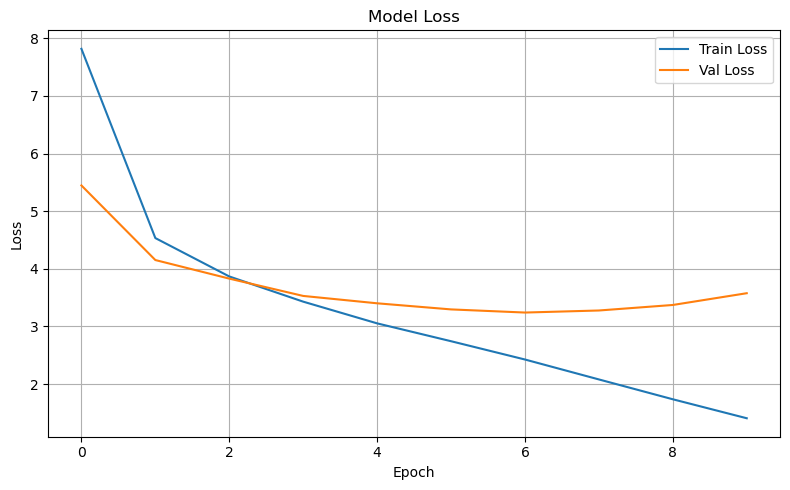

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Terlihat train loss terus turun, tetapi val loss malah naik, artinya model mengalami overfitting.

## Evaluation

In [23]:
def evaluate_accuracy(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            decoder_input = labels[:, :-1]
            target = labels[:, 1:]

            output = model(input_ids, decoder_input)
            pred_ids = output.argmax(dim=-1)
            correct += (pred_ids == target).float().sum().item()
            total += target.numel()
    return correct / total

In [24]:
val_acc = evaluate_accuracy(model, val_loader)
print(f"Validation Accuracy (Token-Level): {val_acc:.4f}")

Validation Accuracy (Token-Level): 0.1627


In [25]:
def evaluate_model(model, data_loader, tokenizer):
    model.eval()
    preds = []
    labels_text = []
    total_loss = 0.0

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    for batch in tqdm(data_loader):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)

        decoder_input = labels[:, :-1]
        target = labels[:, 1:]

        with torch.no_grad():
            logits = model(input_ids, decoder_input)

            loss = loss_fn(logits.reshape(-1, logits.size(-1)), target.reshape(-1))
            total_loss += loss.item()

            pred_ids = logits.argmax(dim=-1)

        for pred, label in zip(pred_ids, target):
            pred_text = tokenizer.decode(pred, skip_special_tokens=True)
            label_text = tokenizer.decode(label, skip_special_tokens=True)
            preds.append(pred_text)
            labels_text.append(label_text)

    return {
        "loss": total_loss / len(data_loader),
        "preds": preds,
        "labels": labels_text
    }

In [26]:
results = evaluate_model(model, val_loader, tokenizer)

100%|██████████| 63/63 [00:04<00:00, 13.06it/s]


In [27]:
def compute_f1(preds, labels):
    bin_preds = [1 if p == l else 0 for p, l in zip(preds, labels)]
    return f1_score([1]*len(labels), bin_preds)

f1 = compute_f1(results["preds"], results["labels"])
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.4387


In [28]:
def compute_bleu(references, hypotheses):
    refs = [[ref.split()] for ref in references]
    hyps = [hyp.split() for hyp in hypotheses]
    smoothie = SmoothingFunction().method1
    return corpus_bleu(refs, hyps, smoothing_function=smoothie)

bleu = compute_bleu(results["labels"], results["preds"])
print(f"BLEU score: {bleu:.4f}")

BLEU score: 0.0019


## Export model

In [29]:
torch.save(model.state_dict(), "experiment_6_qa.pt")

In [30]:
# model.load_state_dict(torch.load("experiment_6_qa.pt"))
# model.eval()

## Test QA

In [31]:
def generate_answer(question_text, max_len=MAX_TARGET_LEN, beam_size=3):
    model.eval()
    input_enc = tokenizer(
        f"question: {question_text}",
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_INPUT_LEN
    )
    input_ids = input_enc["input_ids"].to(device)

    sequences = [(torch.full((1, 1), tokenizer.eos_token_id, dtype=torch.long, device=device), 0.0)]

    for _ in range(max_len):
        all_candidates = []
        for seq, score in sequences:
            with torch.no_grad():
                logits = model(input_ids, seq)
            probs = F.log_softmax(logits[:, -1, :], dim=-1)
            topk_probs, topk_ids = probs.topk(beam_size, dim=-1)

            for i in range(beam_size):
                token_id = topk_ids[0, i].unsqueeze(0).unsqueeze(0)
                new_seq = torch.cat([seq, token_id], dim=1)
                new_score = score + topk_probs[0, i].item()
                all_candidates.append((new_seq, new_score))

        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]

        if all(seq[0][0, -1].item() == tokenizer.eos_token_id for seq in sequences):
            break

    best_seq = sequences[0][0][0, 1:]
    return tokenizer.decode(best_seq, skip_special_tokens=True)

In [32]:
model.eval()

for i in range(len(test_data)):
    q = test_data[i]["question"]
    a = generate_answer(q)
    print(f"Q: {q}")
    print(f"Model: {a}")
    print(f"True: {test_data[i]['correct_answer']}\n")

Q: Compounds that are capable of accepting electrons, such as o 2 or f2, are called what?
Model: translation
True: oxidants

Q: What term in biotechnology means a genetically exact copy of an organism?
Model: medicine
True: clone

Q: Vertebrata are characterized by the presence of what?
Model: chordates
True: backbone

Q: What is the height above or below sea level called?
Model: photosynthesis
True: elevation

Q: Ice cores, varves and what else indicate the environmental conditions at the time of their creation?
Model: hall effect
True: tree rings

Q: What chemical signals in plants control different processes?
Model: hormones
True: plant hormones

Q: Meiosis is part of the process of gametogenesis, which is the production of what?
Model: meiosis
True: sperm and eggs

Q: Which type of tree is dominant in temperate forests?
Model: venation
True: deciduous

Q: What kind of viscosity is found in long-chain hydrocarbons?
Model: gene pool
True: highly viscous

Q: Ionic compounds have stron